# Benchmarking Echo State Networks (ESN) on Chaotic Oscillators

This notebook benchmarks the performance of Echo State Networks (ESN) on chaotic oscillators. The ESN is a type of Recurrent Neural Network (RNN) that is particularly well-suited for time series prediction tasks. 

## Setup

In [19]:
import os
import sys
import torch

project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from src.utils.seed_utils import set_global_seeds
except ImportError:
    raise ImportError("Cannot import module. Make sure that the project is on the path")

SEED = 42
set_global_seeds(seed=SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Generate & Preprocess Data for Model


In [20]:
BATCH_SIZE = 32

### Lorenz


Train size: 40000, Test size: 10001, Batch size: 32
(1250, 1, 3)
(1250, 1, 3)


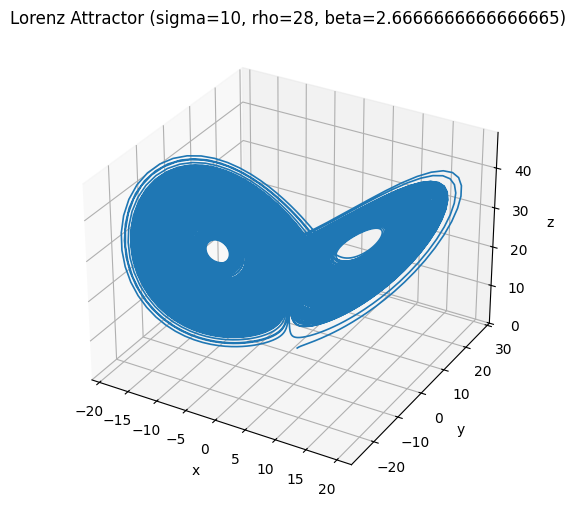

(<Figure size 800x600 with 1 Axes>,
 <Axes3D: title={'center': 'Lorenz Attractor (sigma=10, rho=28, beta=2.6666666666666665)'}, xlabel='x', ylabel='y', zlabel='z'>)

In [21]:
from src.data_sources.lorenz import LorenzOscillator
from src.utils.dataset_utils import DatasetUtils

# For model feed
LORENZ_INPUT_LAYERS = 3
LORENZ_OUTPUT_LAYERS = 3

# Parameters for the Lorenz oscillator
initial_state = [1.0, 1.0, 1.0]
t_span = (0, 500)
max_step = 1e-2

lorenz = LorenzOscillator(sigma=10, rho=28, beta=8.0 / 3.0)

# Create the dataset
dataset = lorenz.preprocess_and_create_dataset(
    initial_state=initial_state,
    t_span=t_span,
    max_step=max_step,
    input_length=1,
    target_length=1,
)

dataset_utils = DatasetUtils()

# Split the dataset
lorenz_train_dataset, lorenz_test_dataset = dataset_utils.train_test_split(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    train_ratio=0.8,
    shuffle_train=True,
    shuffle_test=False,
)

# Convert train/test sets to numpy data
lorenz_X_train, lorenz_Y_train = dataset_utils.dataset_to_numpy(lorenz_train_dataset)
lorenz_X_test, lorenz_Y_test = dataset_utils.dataset_to_numpy(lorenz_test_dataset)

print(lorenz_X_train.shape)
print(lorenz_Y_train.shape)

# Visualize dataset
lorenz.plot_trajectory(initial_state=initial_state, t_span=t_span, max_step=max_step)

## ESN

### Training

In [22]:
from src.models.esn import ESN

esn = ESN(
    input_size=LORENZ_INPUT_LAYERS,
    output_size=LORENZ_OUTPUT_LAYERS,
    units=5000,
    leaking_rate=0.3,
    spectral_radius=1.25,
    ridge=1e-7,
    random_state=SEED
)

esn.fit(lorenz_X_train, lorenz_Y_train)

Running Model-3: 100%|██████████| 1250/1250 [01:34<00:00, 13.24it/s]


Fitting node Ridge-3...


'Model-3': Model('Reservoir-3', 'Ridge-3')

### Evaluation

#### Single-Step Evaluation

In [23]:
import numpy as np

pred_test = esn.predict(lorenz_X_test)  # shape (n_test_samples, 3)
mse_test = np.mean((pred_test - lorenz_Y_test) ** 2)
print(f"ESN single-step MSE on test set: {mse_test:.6f}")

Running Model-3: 100%|██████████| 1/1 [00:00<00:00, 442.53it/s]


ESN single-step MSE on test set: 105.335577


#### Multi-Step Evaluation

Running Model-3: 100%|██████████| 1/1 [00:00<00:00, 270.62it/s]


Multi-step forecast MSE over 200 steps: 763193.571513


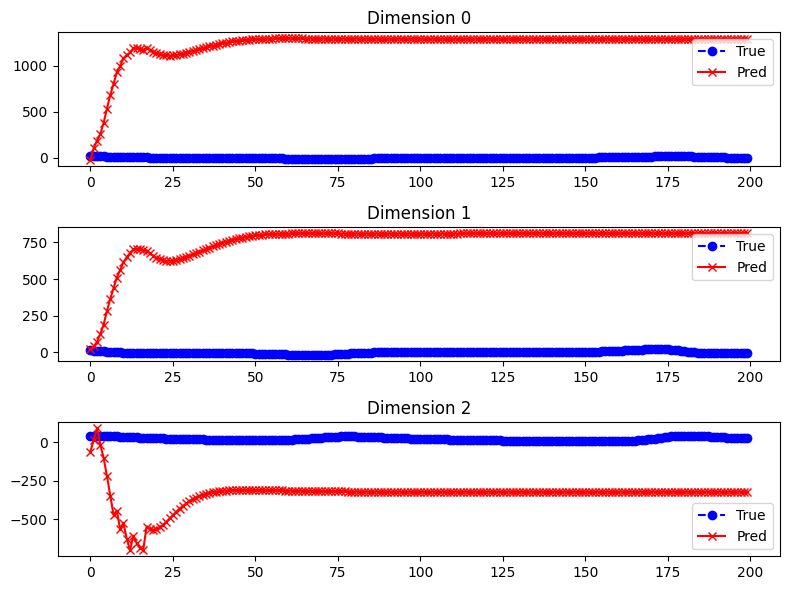

In [ ]:
import matplotlib.pyplot as plt

def multistep_forecast(esn_model, initial_state, steps_ahead):
    """
    Autoregressive multi-step forecast:
      - esn_model: your ESNModel
      - initial_state: shape (3,) (the known state to start from)
      - steps_ahead: number of steps to predict
    Returns array shape (steps_ahead, 3)
    """
    esn_model.reset_state()  # reset reservoir
    current_input = initial_state[np.newaxis, :]  # shape (1,3)
    
    preds = []
    for _ in range(steps_ahead):
        out = esn_model.predict(current_input)  # shape (1,3)
        preds.append(out[0])  # (3,)
        current_input = out   # feed output back as next input (1,3)
    return np.array(preds)    # shape (steps_ahead, 3)

def compare_multistep_prediction(
    esn_model, 
    full_data, 
    start_idx, 
    steps_ahead=50
):
    init_state = full_data[start_idx]  # shape (3,)
    
    # Real future states
    true_future = full_data[start_idx+1 : start_idx+1+steps_ahead]  # shape (steps_ahead, 3)

    # Predict with ESN
    preds = multistep_forecast(esn_model, init_state, steps_ahead)  # shape (steps_ahead, 3)
    
    # Compute MSE
    mse = np.mean((preds - true_future) ** 2)
    print(f"Multi-step forecast MSE over {steps_ahead} steps: {mse:.6f}")
    
    # Plot
    time_axis = np.arange(steps_ahead)
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))
    
    for dim in range(3):
        axes[dim].plot(
            time_axis, 
            true_future[:, dim], 
            label="True", 
            color="blue", 
            linestyle="--", 
            marker="o"
        )
        axes[dim].plot(
            time_axis, 
            preds[:, dim], 
            label="Pred", 
            color="red", 
            marker="x"
        )
        axes[dim].set_title(f"Dimension {dim}")
        axes[dim].legend()
    plt.tight_layout()
    plt.show()

sol = lorenz.solve_trajectory(
    initial_state=initial_state,
    t_span=t_span,
    max_step=max_step
)
# sol.y => shape (3, num_timepoints)
raw_lorenz_data = sol.y.T  # shape (num_timepoints, 3)

start_idx = 30000
steps_ahead = 200

compare_multistep_prediction(
    esn_model=esn,
    full_data=raw_lorenz_data,
    start_idx=start_idx,
    steps_ahead=steps_ahead
)